In [6]:
import numpy as np
import pandas as pd
import geopandas as gpd
import libpysal as ps
import matplotlib.pyplot as plt

from tqdm import tqdm
from mgwr.gwr import GWR
from mgwr.diagnostics import get_AICc
from mgwr.search import equal_interval
from libpysal.weights import lat2W
from multiprocessing.pool import ThreadPool

In [7]:
# Spatial eigenvector extraction function for making smooth simulated data

def extract_sf(w, style='B'):
    w.transform = style
    C, ids = ps.weights.full(w)
    n = C.shape[0]
    M = np.identity(n) - (float(1)/float(n))
    MCM = np.dot(np.dot(M,C),M)
    vals, vecs = np.linalg.eigh(MCM)
    vals, vecs = np.array(vals), np.array(vecs.T)
    #Sort vals and vecs because they aren't in decending order in python
    pairs = zip(vals, vecs)
    svals = sorted(vals, reverse=True)
    stups = [None] * len(svals)
    for e_val, vector in pairs:
        stups[svals.index(e_val)] = (e_val, vector)
        svals[svals.index(e_val)] = None
    vecs = np.array([x[1] for x in stups])
    vals = np.array([x[0] for x in stups])
    return vals, vecs

# Make some data

In [135]:
size = 30
n = size**2
noiselvl = 0.25
Wlat = lat2W(nrows=size, ncols=size, rook=False)

evals, evecs = extract_sf(Wlat)
data = {'global' : 0.5*np.ones((size, size)),
        'regional' : evecs[0, :].reshape(size, size), 
        'local' : evecs[9, :].reshape(size, size)}
X = np.random.uniform(size=(size**2, 1))

betas = evecs[2, :].reshape(-1, 1)
y = X*betas + np.random.normal(loc=0, scale=noiselvl, size=(size**2, 1))

grids = np.meshgrid(range(size), range(size))
coords = np.hstack((grids[0].reshape(-1, 1), grids[1].reshape(-1, 1)))

In [51]:
gwr_func = lambda bw : get_AICc(GWR(coords, y, X, bw, kernel='bisquare').fit(lite=True))

In [57]:
_, _, full_output = equal_interval(7, 200, 1, gwr_func)

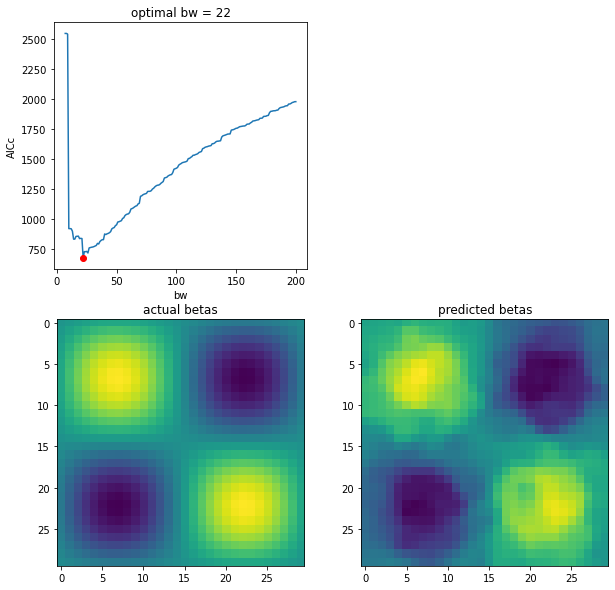

In [58]:
candidates = [x[0] for x in full_output]
losses = [x[1] for x in full_output]

_, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
axes[0, 0].plot(candidates, losses)
axes[0, 0].set_title(f'optimal bw = {candidates[np.argmin(losses)]}')
axes[0, 0].plot(candidates[np.argmin(losses)], min(losses), 'or')
axes[0, 0].set_xlabel('bw')
axes[0, 0].set_ylabel('AICc')

axes[0, 1].set_visible(False)

latmodel = GWR(coords, y, X, candidates[np.argmin(losses)], kernel='bisquare').fit(lite=True)

axes[1, 0].imshow(betas.reshape(size, size))
axes[1, 0].set_title('actual betas')

axes[1, 1].imshow(latmodel.params[:, 1].reshape(size, size))
axes[1, 1].set_title('predicted betas')
plt.show()

# Set up a bigger version with multiscale parameters

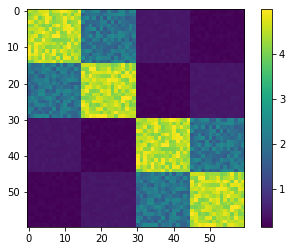

In [206]:
single_pattern = np.block([[np.random.uniform(low=0.4, high=0.5, size=(size//2, size//2)), np.random.uniform(low=0.15, high=0.25, size=(size//2, size//2))],
                           [np.random.uniform(low=0.15, high=0.25, size=(size//2, size//2)), np.random.uniform(low=0.4, high=0.5, size=(size//2, size//2))]])
plt.imshow(np.kron([[10, 1], [1, 10]], single_pattern))
plt.colorbar()
plt.show()

In [207]:
betas = betas.reshape(size, size)
bigbetas = np.kron([[10, 1], [1, 10]], single_pattern)  #np.kron(np.array([[5, -4.5], [-1.5, 3]]), betas)
bigsize = size*2
bigX = np.random.uniform(size=(bigsize**2, 1))
bigy = bigX*bigbetas.reshape(-1, 1) + np.random.normal(loc=0, scale=noiselvl, size=(bigsize**2, 1))
biggrids = np.meshgrid(range(bigsize), range(bigsize))
bigcoords = np.hstack((biggrids[0].reshape(-1, 1), biggrids[1].reshape(-1, 1)))
biggwr_func = lambda bw : get_AICc(GWR(bigcoords, bigy, bigX, bw, kernel='bisquare').fit(lite=True))

In [208]:
_, _, big_full_output = equal_interval(7, 700, 1, biggwr_func)

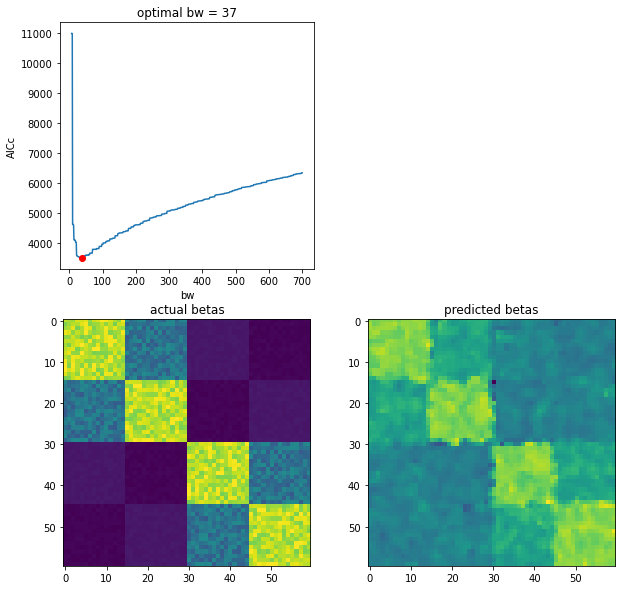

In [209]:
big_candidates = [x[0] for x in big_full_output]
big_losses = [x[1] for x in big_full_output]

_, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
axes[0, 0].plot(big_candidates, big_losses)
axes[0, 0].set_title(f'optimal bw = {big_candidates[np.argmin(big_losses)]}')
axes[0, 0].plot(big_candidates[np.argmin(big_losses)], min(big_losses), 'or')
axes[0, 0].set_xlabel('bw')
axes[0, 0].set_ylabel('AICc')

axes[0, 1].set_visible(False)

bigmodel = GWR(bigcoords, bigy, bigX, 10, kernel='bisquare').fit(lite=True)

axes[1, 0].imshow(bigbetas)
axes[1, 0].set_title('actual betas')

axes[1, 1].imshow(bigmodel.params[:, 1].reshape(bigsize, bigsize))
axes[1, 1].set_title('predicted betas')
plt.show()

$$ \begin{align*} \Huge
    \text{AICc} = -2 \log f(y | \beta, \sigma^2, X) + \frac{2n(k+1)}{n - k - 2}
    \end{align*} $$